## Fashion-MNIST Dataset Overview

The **Fashion-MNIST** dataset is a modern replacement for the classic **MNIST** dataset.  
Instead of handwritten digits, it contains **grayscale images of clothing items** from 10 categories.

- **Number of samples:** 70,000 images  
- **Image size:** 28 × 28 pixels  
- **Channels:** 1 (grayscale)  
- **Number of classes:** 10  

### Class Labels

| Label | Class Name   |
|:------:|:-------------|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


In [4]:
import torch as t
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [5]:
# Define transformations (convert images to tensors and normalize)
transform = transforms.Compose([
                                transforms.ToTensor(),               # Convert image from PIL to Tensor
                                transforms.Normalize((0.5,), (0.5,)) # Normalize pixel values between -1 and 1
                                ])

train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = t.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = t.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


100%|██████████| 26.4M/26.4M [00:11<00:00, 2.32MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 466kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.16MB/s]


## Model Architecture Requirements

The neural network should include the following layers:

- **Input Layer:**  
  - 28 × 28 image flattened into **784 features**  

- **Hidden Layer 1:**  
  - **256 neurons**  
  - **Activation function:** ReLU  

- **Hidden Layer 2:**  
  - **128 neurons**  
  - **Activation function:** ReLU  

- **Output Layer:**  
  - **10 neurons** (one for each class)

### Training Configuration
- **Loss Function:** CrossEntropyLoss  
- **Optimizer:** Adam  
- **Learning Rate:** 0.001


In [6]:
# Build model
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 256) # hidden layer 1: input(28 * 28 is the pixels for each image), output(256)
        self.linear2 = nn.Linear(256, 128) # hidden layer 2: input(256), output(128)
        self.final = nn.Linear(128, 10)    # ourput layer: input(128), output(10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28) # convert + flatten
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x
net = Net()

cross_el = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(net.parameters(), lr=0.001) #e-1

## Training Setup

Train the network using the following configuration:

- **Batch Size:** 64  
- **Epochs:** Between 5 and 10  
- **Input Normalization:** Scale pixel values between **0 and 1**  
- **Training Data:** Used for model learning  
- **Test Data:** Used for evaluation


In [7]:
epoch = 10

for epoch in range(epoch):
    net.train()

    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = net(x.view(-1, 28*28))
        loss = cross_el(output, y)
        loss.backward()
        optimizer.step()

## Evaluation and Submission

After training your model, report the following results:

- **Final training and test accuracy**  
- **Confusion matrix** for the test set  
- **Example images** showing model predictions (both correct and incorrect)

In [8]:
correct = 0
total = 0

with t.no_grad():
    for data in test_loader:
        x, y = data
        output = net(x.view(-1, 784))
        for idx, i in enumerate(output):
            if t.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.883


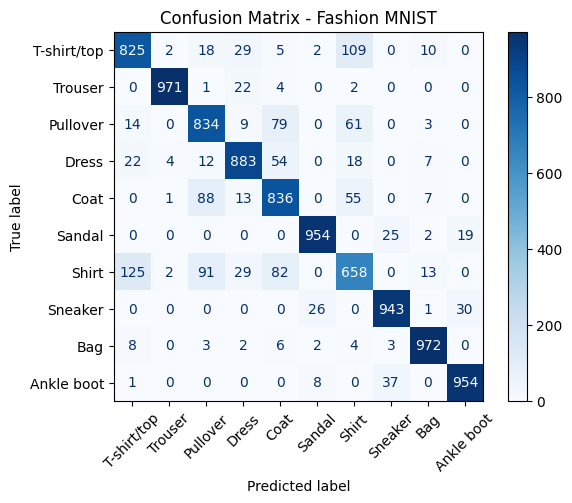

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect all predictions and labels
all_preds = []
all_labels = []

with t.no_grad():
    for x, y in test_loader:
        output = net(x.view(-1, 28*28))
        preds = t.argmax(output, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Fashion MNIST")
plt.show()


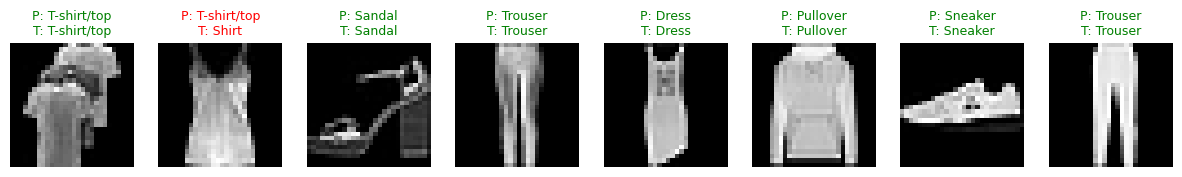

In [10]:
def show_predictions(model, loader, num_images=8):
    model.eval()
    images, labels = next(iter(loader))
    outputs = model(images.view(-1, 784))
    preds = t.argmax(outputs, dim=1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if preds[i] == labels[i] else 'red'
        axes[i].set_title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}",
                          color=color, fontsize=9)
        axes[i].axis('off')
    plt.show()

show_predictions(net, test_loader)


In [11]:
train_losses = []
train_accuracies = []

for epoch in range(10):
    net.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        output = net(x.view(-1, 784))
        loss = cross_el(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = t.argmax(output, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.3f}")


Epoch 1: Loss=0.2118, Accuracy=0.921
Epoch 2: Loss=0.2009, Accuracy=0.924
Epoch 3: Loss=0.1957, Accuracy=0.926
Epoch 4: Loss=0.1859, Accuracy=0.929
Epoch 5: Loss=0.1774, Accuracy=0.933
Epoch 6: Loss=0.1664, Accuracy=0.938
Epoch 7: Loss=0.1630, Accuracy=0.939
Epoch 8: Loss=0.1566, Accuracy=0.940
Epoch 9: Loss=0.1514, Accuracy=0.942
Epoch 10: Loss=0.1449, Accuracy=0.945


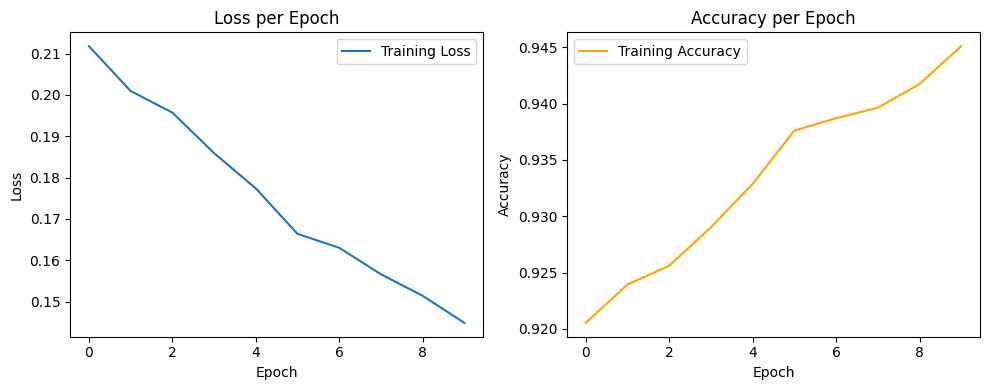

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()